# Uni-Mol Molecular Property Prediction

**Licenses**

Copyright (c) DP Technology.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.

**Citations**

Please cite the following papers if you use this notebook:

- Gengmo Zhou, Zhifeng Gao, Qiankun Ding, Hang Zheng, Hongteng Xu, Zhewei Wei, Linfeng Zhang, Guolin Ke. "[Uni-Mol: A Universal 3D Molecular Representation Learning Framework.](https://chemrxiv.org/engage/chemrxiv/article-details/6318b529bada388485bc8361)"
ChemRxiv (2022)

## Data Preparation (SMILES, label to .lmdb)

In [1]:
import os
import lmdb
import pickle
import time
import pandas as pd
from pathlib import Path

from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  
import warnings
warnings.filterwarnings(action='ignore')
from multiprocessing import Pool
import torch
import io 

## Finetuning (based on pretraining)

## Inference

## Read inference results (.pkl to .csv)

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def get_csv_results(predict_path, csv_path):
    with open(predict_path, 'rb') as f:
        predict = CPU_Unpickler(f).load()
    smi_list, predict_list = [], []
    target_list = []
    for batch in predict:
        sz = batch["bsz"]
        for i in range(sz):
            smi_list.append(batch["smi_name"][i])
            predict_list.append(batch["predict"][i][0].cpu().tolist())
            target_list.append(batch["target"][i][0].cpu().tolist())
    predict_df = pd.DataFrame({"SMILES": smi_list, "predict": predict_list, "target": target_list})
    predict_df = predict_df.groupby("SMILES").mean().reset_index()
    predict_df.to_csv(csv_path,index=False)
    return predict_df


def collect_exp(exp_dir: Path) -> pd.DataFrame:
    if not isinstance(exp_dir, Path):
        exp_dir = Path(exp_dir)

    predict_df_list = []
    for i in range(0, 10):
        # predict_dir = Path(f"/scratch/ssd004/datasets/cellxgene/unimol_pred/220k-20240508-1731/{i}")
        # predict_dir = Path(f"/fs01/datasets/cellxgene/unimol_pred/220k-20240508-1741/{i}")
        predict_dir = exp_dir / f"{i}"
        predict_path = [i for i in predict_dir.glob("*_test.out.pkl")][0]
        csv_path=predict_dir / f"pred.csv"
        predict_df = get_csv_results(predict_path, csv_path)
        predict_df_list.append(predict_df)
        
    combined_df = pd.concat(predict_df_list).reset_index()

    combined_df_sorted = combined_df.sort_values(by="predict", ascending=False)
    combined_df_sorted["rank"] = range(1, len(combined_df_sorted)+1)
    combined_df_sorted["id"] = combined_df_sorted.index.values
    return combined_df_sorted, combined_df

In [3]:
exps = [
    "/fs01/datasets/cellxgene/unimol_pred/220k-save_4CR_0508-24_0.82_0502-1907",
    "/fs01/datasets/cellxgene/unimol_pred/220k-save_4CR_0508-24_0.85_raw_weight_custom_data",
    "/fs01/datasets/cellxgene/unimol_pred/220k-save_4CR_0509-24_0.82_0508-1056"
]
exp_dfs = []
for exp in exps:
    combined_df_sorted, combined_df = collect_exp(exp)
    print(combined_df_sorted.loc[101149])
    exp_dfs.append(combined_df_sorted)

combined_df_sorted

index                                                  12677
SMILES     CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(CC)CC...
predict                                             0.435436
target                                                  -1.0
rank                                                     452
id                                                    101149
Name: 101149, dtype: object
index                                                  12677
SMILES     CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(CC)CC...
predict                                            -0.228749
target                                                  -1.0
rank                                                  185423
id                                                    101149
Name: 101149, dtype: object
index                                                  12677
SMILES     CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(CC)CC...
predict                                             0.077047
target                       

,index,SMILES,predict,target,rank,id
69968,3614,CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CCN1CCCC1)C(CCCC...,0.539950,-1.0,1,69968
69992,3638,CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CCN1CCCC1)C(CCCC...,0.537664,-1.0,2,69992
70635,4281,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC1CCCCC1)N(CCN1...,0.535112,-1.0,3,70635
70654,4300,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC1CCCCC1)N(CCN1...,0.530562,-1.0,4,70654
70655,4301,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC1CCCCC1)N(CCN1...,0.528920,-1.0,5,70655
...,...,...,...,...,...,...
12714,12714,CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCN(C)C)C(...,-0.573198,-1.0,219794,12714
5981,5981,CCCCCCC(CCC)OC(=O)CCCCC(=O)N(CCN(C)C)C(CCCCC)C...,-0.573287,-1.0,219795,5981
10677,10677,CCCCCCCCC(CC)OC(=O)CCCCC(=O)N(CCN(C)C)C(CCCCCC...,-0.573464,-1.0,219796,10677
5992,5992,CCCCCCC(CCC)OC(=O)CCCCC(=O)N(CCN(C)C)C(CCCCCC)...,-0.576127,-1.0,219797,5992


In [4]:
# combine the results in exp_dfs into one result_df, keep the original predict colums and compute the mean predict and mean rank
result_df = pd.concat(exp_dfs)
result_df = result_df.groupby("SMILES").mean().reset_index()
# result_df_sort = result_df.sort_values(by="predict", ascending=False)
result_df

,SMILES,index,predict,target,rank,id
0,C#CCCCCCCCCC(=O)N(C(C(=O)NC(C)(C)C)C(CCCCCC)CC...,0.0,0.014147,-1.0,116788.000000,88472.0
1,C#CCCCCCCCCC(=O)N(C(C(=O)NC(C)(C)C)C(CCCCCC)CC...,0.0,-0.082883,-1.0,130400.666667,0.0
2,C#CCCCCCCCCC(=O)N(C(C(=O)NC(C)(C)C)C(CCCCCC)CC...,0.0,0.035571,-1.0,118095.666667,44236.0
3,C#CCCCCCCCCC(=O)N(C(C(=O)NC(C)(C)CC(C)(C)C)C(C...,1.0,0.027689,-1.0,109100.000000,88473.0
4,C#CCCCCCCCCC(=O)N(C(C(=O)NC(C)(C)CC(C)(C)C)C(C...,1.0,-0.081753,-1.0,130299.000000,1.0
...,...,...,...,...,...,...
214263,CCCCCCCCCCOC(=O)CCCCC(=O)N(c1nccs1)C(CCCCCOC(=...,22113.0,0.190366,-1.0,66146.666667,219793.0
214264,CCCCCCCCCCOC(=O)CCCCC(=O)N(c1nccs1)C(CCCCCOC(=...,22114.0,0.140198,-1.0,92760.333333,219794.0
214265,CCCCCCCCCCOC(=O)CCCCC(=O)N(c1nccs1)C(CCCCCOC(=...,22115.0,0.172130,-1.0,75961.666667,219795.0
214266,CCCCCCCCCCOC(=O)CCCCC(=O)N(c1nccs1)C(CCCCCOC(=...,22116.0,0.181710,-1.0,70132.000000,219796.0


In [5]:
result_df[result_df["id"] == 101149]

,SMILES,index,predict,target,rank,id
122275,CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(CC)CC...,12677.0,0.094578,-1.0,97879.666667,101149.0


In [6]:
result_df_sort = result_df.sort_values(by="rank")
result_df_sort

,SMILES,index,predict,target,rank,id
7947,C=CCCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCCCCC)C(=O)...,690.0,0.317054,-1.0,15403.666667,67044.0
138767,CCCCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCCCCC)C(=O)N...,14259.0,0.315485,-1.0,16326.333333,80613.0
104891,CCCCCCCCC(CCCCCC)C(=O)N(CCCN(C)CCCN)C(CCCCC)C(...,10752.0,0.312145,-1.0,16609.666667,77106.0
89543,CCCCCCCC=CC(=O)N(CCCN(C)CCCN)C(CCCCCCCCC)C(=O)...,9119.0,0.313969,-1.0,16790.666667,75473.0
93851,CCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCC)C(=O)NC12C[...,9597.0,0.311424,-1.0,17159.666667,75951.0
...,...,...,...,...,...,...
124825,CCCCCCCCCC(=O)N(CCCN(C)C)C(CCCCCOC(=O)C(CCCCCC...,13013.0,-0.282425,-1.0,200586.000000,35131.0
64825,CCCCCCCC(=O)N(CCCN(C)C)C(CCCCCOC(=O)C(CCCC)CCC...,6757.0,-0.284461,-1.0,200678.333333,28875.0
93817,CCCCCCCCC(=O)N(CCCN(C)C)C(CCCCCOC(=O)C(CCCC)CC...,9771.0,-0.284183,-1.0,200985.000000,31889.0
93829,CCCCCCCCC(=O)N(CCCN(C)C)C(CCCCCOC(=O)C(CCCCCC)...,9783.0,-0.287309,-1.0,201778.333333,31901.0


Top 30 predicted smiles: 


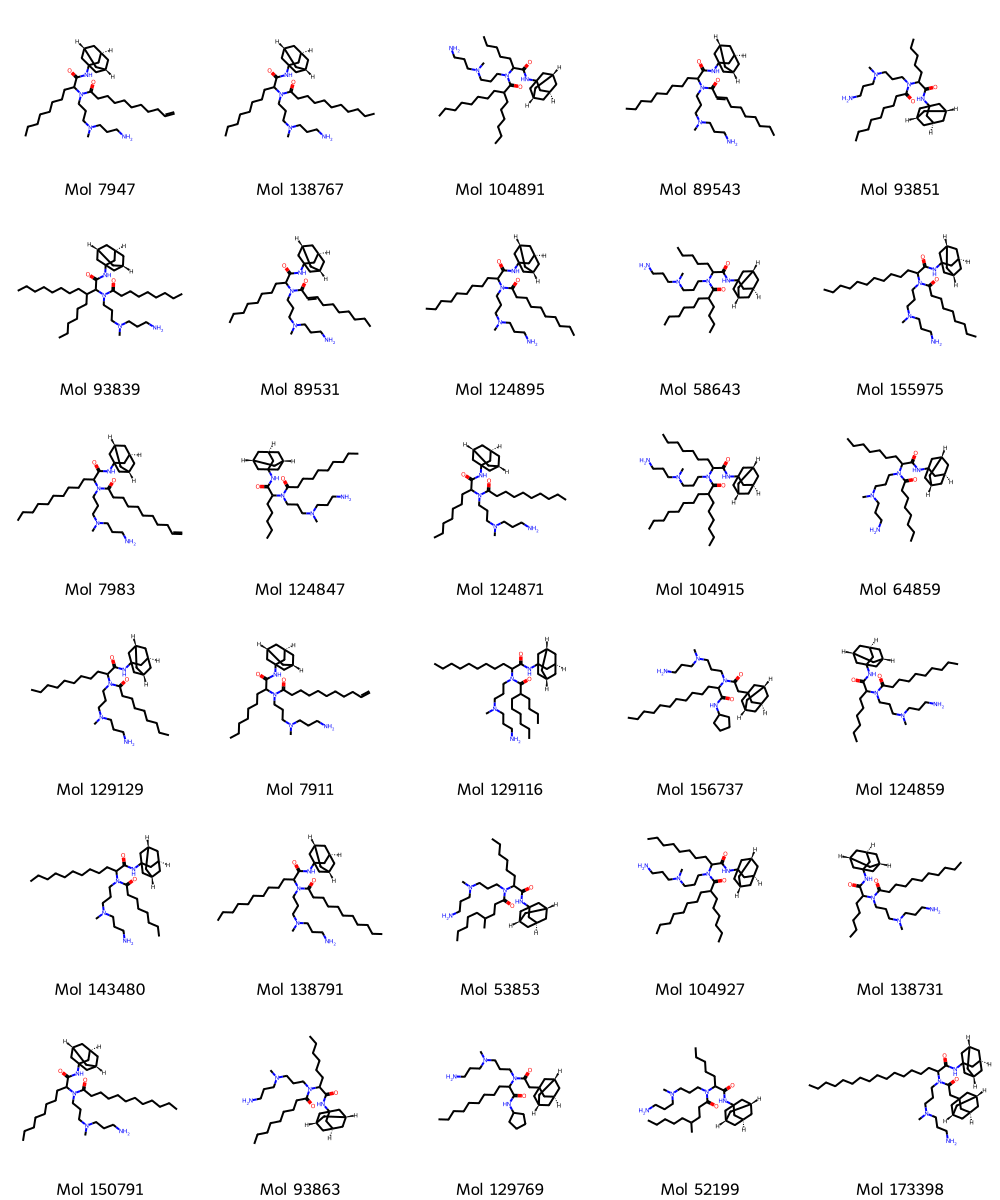

['C=CCCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCCCCC)C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3'
 'CCCCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCCCCC)C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3'
 'CCCCCCCCC(CCCCCC)C(=O)N(CCCN(C)CCCN)C(CCCCC)C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3'
 'CCCCCCCC=CC(=O)N(CCCN(C)CCCN)C(CCCCCCCCC)C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3'
 'CCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCC)C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3'
 'CCCCCCCCC(=O)N(CCCN(C)CCCN)C(C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3)C(CCCCCC)CCCCCCCC'
 'CCCCCCCC=CC(=O)N(CCCN(C)CCCN)C(CCCCCCCC)C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3'
 'CCCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCCCCCC)C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3'
 'CCCCCCC(CCCC)C(=O)N(CCCN(C)CCCN)C(CCCCC)C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3'
 'CCCCCCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3)N(CCCN(C)CCCN)C(=O)CCCCCCCC']


In [7]:
# visualize the first 10 smiles in the SIMILES column
from rdkit.Chem import Draw

print("Top 30 predicted smiles: ")
img = Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smi) for smi in result_df_sort["SMILES"].values[:30]],
    molsPerRow=5,
    legends=[f"Mol {id}" for id in result_df_sort["SMILES"].index[:30]],
)
display(img)
print(result_df_sort["SMILES"].values[:10])

Least 10 predicted smiles: 


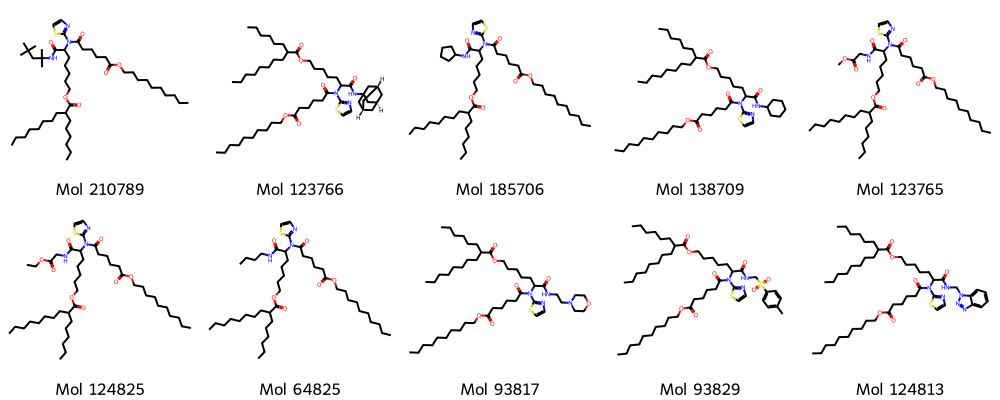

In [8]:
print("Least 10 predicted smiles: ")
img = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in combined_df["SMILES"].values[-10:]], molsPerRow=5, legends=[f"Mol {id}" for id in result_df_sort["SMILES"].index[-10:]])
display(img)

## Converting back to component names

In [9]:
ref_path = '/fs01/home/haotian/SDL-LNP/model/data_process/220k_library.csv'

ref_df = pd.read_csv(ref_path)

ref_df

,id,combined_mol_SMILES,A_smiles,B_smiles,C_smiles,D_smiles
0,0,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CC12C[C@H]3C[C@@...,NCCN(C)C,C[N+]#[C-],CCCCCC=O,OC(CC(C1)(C2)C[C@@H]3C[C@H]2C[C@H]1C3)=O
1,1,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)C[C@@]12C[C@@H]3...,NCCN(C)C,C[N+]#[C-],CCCCCC=O,OC(C[C@@](C1)(C2)C[C@]3(O)C[C@H]2C[C@H]1C3)=O
2,2,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CCN1CCCCC1,NCCN(C)C,C[N+]#[C-],CCCCCC=O,OC(CCN1CCCCC1)=O
3,3,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CN(C)C,NCCN(C)C,C[N+]#[C-],CCCCCC=O,CN(CC(O)=O)C
4,4,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CCN(C)C,NCCN(C)C,C[N+]#[C-],CCCCCC=O,CN(CCC(O)=O)C
...,...,...,...,...,...,...
221179,221179,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,NCCCN1CCCCCC1,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCC/C=C\C/C=C\CCCCCCCC=O,CCCCCCCCC(OC(CCCCC(O)=O)=O)CCCCCCCC
221180,221180,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,NCCCN1CCCCCC1,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCC/C=C\C/C=C\CCCCCCCC=O,CCC(CCC(OC(CCCCC(O)=O)=O)CC(C)C)CCCC
221181,221181,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,NCCCN1CCCCCC1,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCC/C=C\C/C=C\CCCCCCCC=O,OC(CCCCC(OCCCCCCCCCC)=O)=O
221182,221182,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,NCCCN1CCCCCC1,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCC/C=C\C/C=C\CCCCCCCC=O,OC(CCCCC(OCCCCCCCCCCC)=O)=O


In [10]:
component_smiles_path = "/fs01/home/haotian/SDL-LNP/Chem_Doc/SMILES_96_4CR.csv"

component_smiles_df = pd.read_csv(component_smiles_path)

component_smiles_df

,ID,Name,SMILES
0,A1,D5616,NCCN(C)C
1,A2,A2241,NN1CCCCC1
2,A3,A0409,NCCCN1CCOCC1
3,A4,A0304,NCCN1CCNCC1
4,A5,D0790,NCCCN(C)C
...,...,...,...
91,D32,H1401+A0161,CCCCCCCCC(OC(CCCCC(O)=O)=O)CCCCCCCC
92,D33,E0144+A0161,CCC(CCC(OC(CCCCC(O)=O)=O)CC(C)C)CCCC
93,D34,D0031+A0161,OC(CCCCC(OCCCCCCCCCC)=O)=O
94,D35,U0005+A0161,OC(CCCCC(OCCCCCCCCCCC)=O)=O


In [11]:
# mapped_df
# sorted top 96 smiles, pred, a_name, b_name, c_name, d_name, a_smiles, b_smiles, c_smiles, d_smiles

mapped_df = pd.DataFrame(columns=["SMILES", "predict", "a_name", "b_name", "c_name", "d_name", "a_smiles", "b_smiles", "c_smiles", "d_smiles"])

NUM = 96
for smi in result_df_sort["SMILES"].values[:NUM]:
    idx = result_df_sort[result_df_sort["SMILES"] == smi].index[0]
    a_name, b_name, c_name, d_name = None, None, None, None
    a_smiles, b_smiles, c_smiles, d_smiles = None, None, None, None
    row = ref_df[ref_df["combined_mol_SMILES"] == smi]
    a_smiles = row["A_smiles"].values[0]
    b_smiles = row["B_smiles"].values[0]
    c_smiles = row["C_smiles"].values[0]
    d_smiles = row["D_smiles"].values[0]
    a_name = component_smiles_df[component_smiles_df["SMILES"] == a_smiles]["Name"].values[0]
    b_name = component_smiles_df[component_smiles_df["SMILES"] == b_smiles]["Name"].values[0]
    c_name = component_smiles_df[component_smiles_df["SMILES"] == c_smiles]["Name"].values[0]
    d_name = component_smiles_df[component_smiles_df["SMILES"] == d_smiles]["Name"].values[0]
    mapped_df = mapped_df.append({"idx": int(idx),
                                    "SMILES": smi, 
                                  "predict": result_df_sort[result_df_sort["SMILES"] == smi]["predict"].values[0], 
                                  "a_name": a_name, "b_name": b_name, "c_name": c_name, "d_name": d_name, 
                                  "a_smiles": a_smiles, "b_smiles": b_smiles, "c_smiles": c_smiles, "d_smiles": d_smiles}, 
                                 ignore_index=True)
mapped_df

,SMILES,predict,a_name,b_name,c_name,d_name,a_smiles,b_smiles,c_smiles,d_smiles,idx
0,C=CCCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCCCCC)C(=O)...,0.317054,B0821,I0824,N0296,U0007,NCCCN(C)CCCN,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCCCCCC=O,OC(CCCCCCCCC=C)=O,7947.0
1,CCCCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCCCCC)C(=O)N...,0.315485,B0821,I0824,N0296,U0004,NCCCN(C)CCCN,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCCCCCC=O,OC(CCCCCCCCCC)=O,138767.0
2,CCCCCCCCC(CCCCCC)C(=O)N(CCCN(C)CCCN)C(CCCCC)C(...,0.312145,B0821,I0824,H0133,2-hexyldecanoic acid,NCCCN(C)CCCN,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCCC=O,OC(C(CCCCCCCC)CCCCCC)=O,104891.0
3,CCCCCCCC=CC(=O)N(CCCN(C)CCCN)C(CCCCCCCCC)C(=O)...,0.313969,B0821,I0824,D0032,D0098,NCCCN(C)CCCN,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCCCCCCC=O,OC(/C=C/CCCCCCC)=O,89543.0
4,CCCCCCCCC(=O)N(CCCN(C)CCCN)C(CCCCC)C(=O)NC12C[...,0.311424,B0821,I0824,H0133,P0952,NCCCN(C)CCCN,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCCC=O,OC(CCCCCCCC)=O,93851.0
...,...,...,...,...,...,...,...,...,...,...,...
91,CCCCCC(C(=O)NC1CCCC1)N(CCCN(C)CCCN)C(=O)CC12C[...,0.304982,B0821,C2959,H0133,A0736,NCCCN(C)CCCN,[C-]#[N+]C1CCCC1,CCCCCC=O,OC(CC(C1)(C2)C[C@@H]3C[C@H]2C[C@H]1C3)=O,49280.0
92,CCCCCCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H...,0.294815,B0821,I0824,D0979,D0509,NCCCN(C)CCCN,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCCCCCCCCC=O,OC(CN(CC)CC)=O,155982.0
93,CCCCCCCCC(CCCCCC)C(C(=O)NC12C[C@H]3C[C@@H](C1)...,0.297256,B0821,I0824,H1461,O0027,NCCCN(C)CCCN,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCCCCCC(CCCCCC)C=O,CCCCCCCC(O)=O,114447.0
94,CCCCCCCCC(C(=O)NC1CCCC1)N(CCCN(C)CCCN)C(=O)CN(C)C,0.290868,B0821,C2959,N0296,D3585,NCCCN(C)CCCN,[C-]#[N+]C1CCCC1,CCCCCCCCC=O,CN(CC(O)=O)C,97836.0


In [12]:
# mapped_df.to_csv("/scratch/ssd004/datasets/cellxgene/unimol_pred/pred1920/component_mapped.csv", index=False)